# План домашней работы
1. Реализовать алгоритмы **item2item**, **ALS**, **IALS** (2 балла за каждый)
2. Посчитать метрику предсказаний **MRR@100** выбрасывая случайный лайк пользователя (2 балла)

Будем решать задачу предсказания: на 4/5 пользователей учимся, на 1/5 выбрасываем случайный лайк и пытаемся предсказать его беря топ 100 наших лучших предсказаний для этого пользователя.

MRR@100 будет равно $1/(p+1)$, где $p$ - позиция на которой оказался выброшенный лайк в нашем ранжировании и 0 если в топ 100 его не было.

3. Подобрать параметры алгоритмов для максимизации MRR@100 (1 балл)
4. Сравнить похожести айтемов получаюшиеся для item2item, ALS, IALS (1 балл)

Замерить насколько получаются похожими топы похожестей. Так же рекомендуется взять 5-топовых (или любимых) треков и посмотреть на похожести которые получаются для них в разных алгоритмах.

### Ссылки на датасет музыки:

1. Матричка: https://disk.yandex.ru/d/cLbDbw3mCido_w
2. Имена айтемов: https://disk.yandex.ru/d/pPCaGJOqcpcABw
3. Линки между айтемами: https://disk.yandex.ru/d/hMErnDJqtVm9HQ

### Загрузка данных для Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Вместо data_train.zip загрузим сразу обработанную user-item матрицу data_train.npz

In [3]:
%%time
!cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/RecSys/HW1/data_train.npz data_train.npz 
!cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/RecSys/HW1/yt___home_music_recom_burlada_recsys_2022_02_19_public_all_names.zip yt___home_music_recom_burlada_recsys_2022_02_19_public_all_names.zip 
!cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/RecSys/HW1/yt___home_music_recom_burlada_recsys_2022_02_19_public_tracks_links.zip yt___home_music_recom_burlada_recsys_2022_02_19_public_tracks_links.zip 
# !cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/RecSys/HW1/yt___home_music_recom_burlada_recsys_2022_02_19_public_data_train.zip yt___home_music_recom_burlada_recsys_2022_02_19_public_data_train.zip 

CPU times: user 94.2 ms, sys: 20.7 ms, total: 115 ms
Wall time: 9.4 s


# 0. Разбираемся с датасетом музыки

In [4]:
import os, zipfile
import numpy as np
import pandas as pd
import scipy.sparse as sp
from tqdm.notebook import tqdm, tnrange

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
base_name = "yt___home_music_recom_burlada_recsys_2022_02_19_"
for fname in tqdm([n for n in os.listdir(".") if base_name in n and n.endswith(".zip")]):
    extract_name = fname.replace(".zip", "")
    if os.path.exists(extract_name): continue
    with zipfile.ZipFile(fname) as f:
        f.extract(f.filelist[0])

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
all_names = pd.read_json("yt___home_music_recom_burlada_recsys_2022_02_19_public_all_names", lines=True)
track_links = pd.read_json("yt___home_music_recom_burlada_recsys_2022_02_19_public_tracks_links", lines=True)
# dataset = pd.read_json("yt___home_music_recom_burlada_recsys_2022_02_19_public_data_train", lines=True)

In [7]:
track_names = all_names[all_names.type == "track"].set_index("id").name.to_dict()
artist_names = all_names[all_names.type == "artist"].set_index("id").name.to_dict()
track_artists = track_links.set_index("track_id").artists.to_dict()
track_artists_names = {track_id: ", ".join([artist_names[a] for a in artists]) 
                       for track_id, artists in track_artists.items()}

def items_info(items_list):
    return pd.DataFrame([{"artist": track_artists_names[track_id], 
                          "track": track_names[track_id], 
                          "id": track_id} for track_id in items_list])

In [ ]:
# total_interactions_count = dataset.track_ids.map(len).sum()
# user_coo, item_coo = np.zeros(total_interactions_count, dtype=np.int32), np.zeros(total_interactions_count, dtype=np.int32)
# pos = 0
# for u, tracks in enumerate(tqdm(dataset.track_ids)):
#     user_coo[pos:pos+len(tracks)] = u
#     item_coo[pos:pos+len(tracks)] = tracks
#     pos += len(tracks)
# shape = (max(user_coo) + 1, max(item_coo) + 1)
# user_item_matrix = sp.coo_matrix((np.ones(len(user_coo)), (user_coo, item_coo)), shape=shape)
# user_item_matrix = user_item_matrix.tocsr()
# sp.save_npz("data_train.npz", user_item_matrix)
# # Cleanup memory. Later you need just data_train.npz
# del user_coo
# del item_coo
# del dataset

In [8]:
user_item_matrix = sp.load_npz("data_train.npz")
user_item_matrix

<1373221x101521820 sparse matrix of type '<class 'numpy.float64'>'
	with 222629898 stored elements in Compressed Sparse Row format>

In [9]:
item_weights = np.array(user_item_matrix.tocsc().sum(0))[0]
top_to_bottom_order = np.argsort(-item_weights)
item_mapping = np.empty(top_to_bottom_order.shape, dtype=int)
item_mapping[top_to_bottom_order] = np.arange(len(top_to_bottom_order))
total_item_count = (item_weights > 0).sum()
total_user_count = user_item_matrix.shape[0]

def build_dataset(user_item_matrix, item_pct, user_pct):
    user_count, item_count = int(total_user_count * user_pct), int(total_item_count * item_pct)
    item_ids = top_to_bottom_order[:item_count]
    user_ids = np.random.choice(np.arange(user_item_matrix.shape[0]), size=user_count, replace=False)
    train = user_item_matrix[user_ids]
    train = train[:, item_ids]
    return train, item_ids

In [10]:
small_dataset, item_ids = build_dataset(user_item_matrix, 0.01, 0.01)
small_dataset = small_dataset.tocsc()
del user_item_matrix

In [11]:
small_dataset

<13732x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 964795 stored elements in Compressed Sparse Column format>

Маппинг, пример:

* `item_mapping[53404] -> 0`: трек с исходным порядковым id = 53404 стоит в датасете на позиции 0
* `item_ids[0] -> 53404`: на позиции 0 (в первой колонке датасета) трек с исходным id = 53404

## 1. Реализация алгоритмов

### Подготовка датасета 

Создадим датасет, где у 1/5 случайных (тестовых) юзеров с кол-вом лайков выше заданного (например, 10) удален 1 случайный лайк

In [12]:
def train_test_split(dataset, likes_threshold=10, test_share=0.2, verbose=True):
    n_users = dataset.shape[0]
    test_users_count = int(n_users * test_share)

    users_likes_count = dataset.tocsr().sum(axis=1)
    users_mask = (users_likes_count > likes_threshold).A.reshape(-1)
    users_ids_with_enough_likes = np.arange(n_users)[users_mask]

    if verbose: print(f'Total users: {n_users}, users with enough likes: {users_mask.sum()}, test users: {test_users_count}')

    test_users_ids = np.random.choice(users_ids_with_enough_likes, size=test_users_count, replace=False)   
    test_items_ids = np.zeros(shape=(test_users_count,)).astype(int)

    dataset_lil = dataset.tolil() # for a effective matrix sparsity structure changes

    for i, user_id in tqdm(enumerate(test_users_ids), total=len(test_users_ids)):
        nonzero_indices = dataset_lil.rows[user_id]
        random_index = np.random.choice(nonzero_indices)
        test_items_ids[i] = random_index
        dataset_lil[user_id, random_index] = 0

    dataset_train = dataset_lil.tocsc()
    removed_likes = dataset.getnnz() - dataset_train.getnnz()

    # check that for each test user sum of likes descreased by 1
    assert np.all(dataset[test_users_ids].tocsr().sum(axis=1) == dataset_train[test_users_ids].tocsr().sum(axis=1) + 1)

    if verbose: print(f'Total likes before: {dataset.getnnz()}, after: {dataset_train.getnnz()}, removed: {removed_likes}')

    return dataset_train, test_users_ids, test_items_ids

In [13]:
dataset_train, test_users_ids, test_items_ids = train_test_split(small_dataset)

Total users: 13732, users with enough likes: 10401, test users: 2746


  0%|          | 0/2746 [00:00<?, ?it/s]

Total likes before: 964795, after: 962049, removed: 2746


### item2item

1. Посчитаем sparse-матрицу попарных IoU (Jaccard) между айтемами
2. Найдем top-K ближайших соседей для каждого айтема
3. По истории юзера найдем кандидатов и рассчитаем их схожесть с историей юзера
4. Отранжируем по схожести и порекомендуем топ-100 лучших предсказаний

In [14]:
def jaccard_pairwise_similarity(dataset, verbose=True):
    if verbose: print(f'Users: {dataset.shape[0]}, Items: {dataset.shape[1]}')

    intersection = dataset.T * dataset
    items_likes_count = dataset.getnnz(axis=0)
    union = (
        np.repeat(items_likes_count, intersection.getnnz(axis=0)) + 
        items_likes_count[intersection.indices] - 
        intersection.data
    )
    similarities = intersection.copy()
    similarities.data /= union

    if verbose: print(f'Similarities matrix: {similarities.shape}')
    return similarities

def top_k_neighbors(similarity_matrix, k=30, verbose=True):
    n_items = similarity_matrix.shape[0]
    similarities = np.zeros(shape=(n_items, k))
    neighbors = np.zeros(shape=(n_items, k))

    for i in tqdm(range(n_items)):
        item_similarities = similarity_matrix[i].toarray()[0]
        indices = item_similarities.argpartition(-k)[-k:]
        similarities[i] = np.flip(np.sort(item_similarities[indices]))
        neighbors[i] = indices[np.flip(np.argsort(item_similarities[indices]))]

    if verbose: print(f'Neighbors similarities and indices matrices: {neighbors.shape}')
    return similarities, neighbors

In [15]:
similarity_matrix = jaccard_pairwise_similarity(dataset_train)
similarities, neighbors = top_k_neighbors(similarity_matrix)

Users: 13732, Items: 10000
Similarities matrix: (10000, 10000)


  0%|          | 0/10000 [00:00<?, ?it/s]

Neighbors similarities and indices matrices: (10000, 30)


In [16]:
def candidate_items(dataset, neighbors, user_id, k=20, verbose=True):
    user_item_ids = dataset.tocsr()[user_id].indices # unsorted for csr dataset

    candidates = set()
    for item_id in user_item_ids:
        candidates.update(neighbors[item_id, :k])

    candidates_ = np.sort(np.setdiff1d(list(candidates), user_item_ids, assume_unique=True).astype(int))
    
    if verbose: print(f'User: {user_id}, n_items: {len(user_item_ids)}, candidates: {len(candidates)}, candidates filtered: {len(candidates_)}')
    return user_item_ids, candidates_

def similarity_with_user_items(candidate_id, user_item_ids, similarities, neighbors):
    w = 0
    for user_item_id in user_item_ids:
        if candidate_id in neighbors[user_item_id]:
            w += similarities[user_item_id, neighbors[user_item_id] == candidate_id][0]
    return w

def rank_candidates(candidates, user_item_ids, similarities, neighbors):
    sims = [similarity_with_user_items(c, user_item_ids, similarities, neighbors) for c in candidates]
    candidates_track_ids = [item_ids[c] for c in candidates]
    tuples = list(zip(candidates_track_ids, sims))
    ranked_candidates = sorted(tuples, key=lambda couple: couple[1], reverse=True)    
    return ranked_candidates

def top_N_recommendation(dataset, user_id, similarities, neighbors, k=20, N=100, verbose=False):
    """
    k: количество кандидатов с каждого айтема из истории юзера
    N: итоговое количество рекомендаций для пользователя
    """
    user_item_ids, candidates = candidate_items(dataset, neighbors, user_id, k, verbose)
    ranked_candidates = rank_candidates(candidates, user_item_ids, similarities, neighbors)

    if verbose: print(f'{len(candidates)} candidates are sorted by relevance')
    return ranked_candidates[:N]

def top_N_recommendation_df(dataset, user_id, similarities, neighbors, k=20, N=100, verbose=True):
    recommendations = top_N_recommendation(dataset, user_id, similarities, neighbors, k, N, verbose)

    top_N = pd.DataFrame(recommendations, columns=['item_id', 'similarity_with_Iu'])
    items_info = pd.DataFrame([{"artist": track_artists_names[item_id], 
                                "track": track_names[item_id], 
                                "item_id": item_id} for item_id in top_N['item_id']])
    top_N = pd.merge(top_N, items_info, on='item_id', how='inner')

    if verbose: print(f'Top-{N} recommended items are ready!')
    return top_N

In [17]:
# пример рекомендации для юзера 0
top_N_recommendation_df(dataset_train, 0, similarities, neighbors)

User: 0, n_items: 44, candidates: 540, candidates filtered: 496
496 candidates are sorted by relevance
Top-100 recommended items are ready!


,item_id,similarity_with_Iu,artist,track
0,44184116,1.320111,Тима Белорусских,Незабудка
1,58515506,1.310625,GAYAZOV$ BROTHER$,Увезите меня на Дип-хаус
2,60725745,1.271601,Мэвл,Патамушка
3,50834580,1.211626,HammAli & Navai,Девочка-война
4,53357546,1.184877,Джаро & Ханза,Королева танцпола
...,...,...,...,...
95,34735046,0.302681,Hippie Sabotage,Devil Eyes
96,32038184,0.301396,Макс Корж,Жить в кайф
97,48591809,0.301041,"Jillzay, Скриптонит, Cheenah, 104, Magg '98, K...",Бар «2 лесбухи»
98,58306539,0.297555,NK,Elefante


#### Протестируем на двух синтетических историях

In [18]:
def top_N_recommendations_by_user_history(user_tracks_ids, similarities, neighbors, k=20, N=10):
    user_item_ids = [item_mapping[i] for i in user_tracks_ids]

    candidates = set()
    for item_id in user_item_ids:
        candidates.update(neighbors[item_id, :k])
    candidates = np.sort(np.setdiff1d(list(candidates), user_item_ids, assume_unique=True).astype(int))

    ranked_candidates = rank_candidates(candidates, user_item_ids, similarities, neighbors)
    top_N = pd.DataFrame(ranked_candidates[:N], columns=['item_id','similarity_with_Iu'])    
    items_info = pd.DataFrame([{"artist": track_artists_names[item_id], 
                                "track": track_names[item_id], 
                                "item_id": item_id} for item_id in top_N['item_id']])
    top_N = pd.merge(top_N, items_info, on='item_id', how='inner')
    return top_N

def show_i2i_comparison(similarities, neighbors, test_history):
    display(items_info(test_history))
    display(top_N_recommendations_by_user_history(test_history, similarities, neighbors))

In [19]:
test_history_1 = [96089, 48951, 53404, 1710810, 148345, 6705392, 628970]
show_i2i_comparison(similarities, neighbors, test_history_1)

,artist,track,id
0,Blur,Song 2,96089
1,Bon Jovi,It's My Life,48951
2,Nirvana,Smells Like Teen Spirit,53404
3,Queen,Another One Bites The Dust,1710810
4,Red Hot Chili Peppers,Californication,148345
5,The White Stripes,Seven Nation Army,6705392
6,Three Days Grace,I Hate Everything About You,628970


,item_id,similarity_with_Iu,artist,track
0,37384,1.040177,The Cranberries,Zombie
1,694683,1.037306,AC/DC,Highway to Hell
2,178495,1.009594,Linkin Park,In the End
3,178529,0.982242,Linkin Park,Numb
4,214489,0.865540,Red Hot Chili Peppers,Can't Stop
5,630670,0.786585,The Offspring,"You're Gonna Go Far, Kid"
6,646516,0.781337,System of A Down,Chop Suey!
7,27032843,0.737999,Pain,Shut Your Mouth
8,328683,0.712365,Evanescence,Bring Me To Life
9,648937,0.674361,System of A Down,Lonely Day


In [20]:
test_history_2 = [28421152, 48592062, 34362335, 39548432, 33308946, 68562711, 83063895]
show_i2i_comparison(similarities, neighbors, test_history_2)

,artist,track,id
0,Oxxxymiron,Башня из слоновой кости,28421152
1,"Скриптонит, 104",Цепи,48592062
2,ATL,Танцуйте,34362335
3,Jah Khalib,Воу-воу палехчэ,39548432
4,Бумбокс,Вахтёрам,33308946
5,Ramil',Сияй,68562711
6,HammAli & Navai,Птичка,83063895


,item_id,similarity_with_Iu,artist,track
0,48591748,0.450339,"Скриптонит, T-Fest",Ламбада
1,48592132,0.442894,Скриптонит,Животные
2,48592141,0.428837,Скриптонит,Положение
3,48592489,0.421331,Скриптонит,Это любовь
4,48591809,0.403845,"Jillzay, Скриптонит, Cheenah, 104, Magg '98, K...",Бар «2 лесбухи»
5,48592437,0.396911,Скриптонит,Танцуй сама
6,66322065,0.379137,HENSY,Поболело и прошло
7,67538121,0.356990,HammAli & Navai,А если это любовь?
8,76434671,0.354017,Султан Лагучев,Горький вкус
9,78608850,0.347141,10AGE,Нету интереса


__Вывод__

* Item2Item работает адекватно, в топе рекомендованных песен треки совпадают по стилю в каждом из примеров - зарубежный рок в наборе 1 и русский хип-поп/рэп в наборе 2.

---

### ALS

1. Сгенирируем дизлайки "-1" для каждого юзера в кол-ве х2 от его кол-ва лайков, выберем айтемы для дизлайков с вероятностью пропорциональной корню популярности айтема
2. Применим алгоритм ALS для разложения матрицы users-items на $X$ и $Y$
  - Для быстрой работы алгоритма будем обновлять матрицы $X$ и $Y$ сразу целиком, а не построчно $X[i]$ и $Y[j]$, интерпретируя нули матрицы (отсутствие фидбека), как некоторый "нейтральный" фидбек
3. Порекомендуем топ айтемов с наибольшим значением в восстановленной матрице $XY^T$

In [21]:
def add_negative_feedback(dataset):
    n_users, n_items = dataset.shape
    items_indices = np.arange(n_items)

    # likes per user multiplied by 2
    dislikes_to_generate = (dataset.sum(axis=1) * 2).astype(int)
    # root of items popularity as weights for sampling
    items_weights = np.sqrt(dataset.sum(axis=0))

    for i in tqdm(range(n_users)):
        likes_indices = np.nonzero(dataset[i])[0]
        zeros_indices = np.setdiff1d(items_indices, likes_indices, assume_unique=True).astype(int)
        
        # sample zero items for dislikes and keep Σp=1
        items_probabilities = items_weights[zeros_indices]
        items_probabilities /= items_probabilities.sum()

        dislikes_indices = np.random.choice(zeros_indices, 
                                            size=dislikes_to_generate[i], 
                                            p=items_probabilities)
        dataset[i, dislikes_indices] = -1

In [22]:
dataset_als = dataset_train.toarray()
add_negative_feedback(dataset_als)

  0%|          | 0/13732 [00:00<?, ?it/s]

In [25]:
def calc_oposite_vectors(Y, A, lam, k):
    B = Y.T.dot(Y) + lam * np.eye(k)
    R = A.dot(Y)
    return np.linalg.inv(B).dot(R.T).T

def ALS(A, n_steps=20, k=32, lam=1e-4):
    X = np.random.randn(A.shape[0], k)
    Y = np.random.randn(A.shape[1], k)

    # Frobenius norms
    loss_history = [np.sum((A - X.dot(Y.T))**2)] 

    for i in tqdm(range(n_steps)):
        X = calc_oposite_vectors(Y, A, lam, k)
        loss_history.append(np.sum((A - X.dot(Y.T))**2))
        Y = calc_oposite_vectors(X, A.T, lam, k)
        loss_history.append(np.sum((A - X.dot(Y.T))**2))

    return X, Y, loss_history

In [26]:
X, Y, loss_history = ALS(dataset_als)

als_predicted = X.dot(Y.T)

  0%|          | 0/20 [00:00<?, ?it/s]

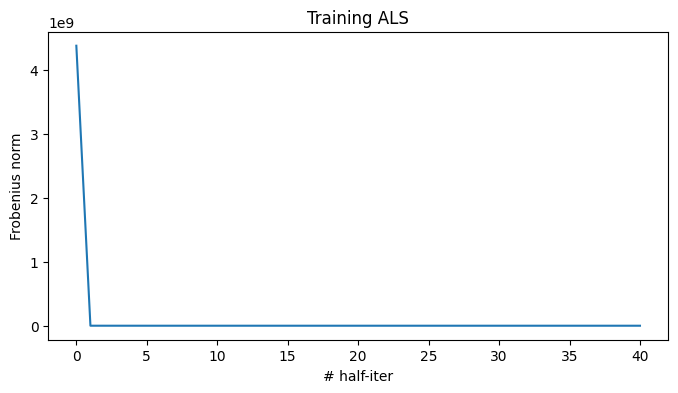

In [27]:
plt.figure(figsize=(8,4))
plt.plot(loss_history)
plt.title("Training ALS")
plt.xlabel("# half-iter")
plt.ylabel("Frobenius norm")
plt.show()

#### Посмотрим примеры рекомендаций для случайной пары юзеров

In [33]:
def top_N_recs_ALS(dataset, als_predicted, user_id, N=10):
    user_history = dataset.tocsr()[user_id].indices
    user_predictions = als_predicted[user_id]

    # занулим релевантность айтемов из истории юзера, чтобы не рекомендовать их
    user_predictions[user_history] = 0 

    indices = user_predictions.argpartition(-N)[-N:]
    recs = np.array([item_ids[i] for i in indices[np.flip(np.argsort(user_predictions[indices]))]], dtype=int)
    return recs

def get_user_history(dataset, user_id):
    return [item_ids[i] for i in dataset.tocsr()[user_id].indices]

def show_ALS_comparison(dataset, als_predicted, user_id):
    history = get_user_history(dataset, user_id)[:15]
    recs = top_N_recs_ALS(dataset, als_predicted, user_id)
    display(items_info(history))
    display(items_info(recs))

In [34]:
show_ALS_comparison(dataset_train, als_predicted, user_id=0)

,artist,track,id
0,"Miyagi & Эндшпиль, Рем Дигга",I Got Love,35505245
1,"Тайпан, Agunda",Луна не знает пути,61565558
2,Макс Корж,2 типа людей,56776952
3,Тима Белорусских,Мокрые кроссы,43052381
4,Тима Белорусских,Витаминка,49125069
5,Звонкий,Голоса,43716993
6,RASA,Пчеловод,54837415
7,Little Big,UNO,63591534
8,Tanir & Tyomcha,Da Da Da,56671420
9,"RSAC, ELLA",NBA (Не мешай),53996716


,artist,track,id
0,RSAC,NBA,43942453
1,Тима Белорусских,Незабудка,44184116
2,NILETTO,Любимка,52380688
3,GAYAZOV$ BROTHER$,Увезите меня на Дип-хаус,58515506
4,Sub Urban,Cradles,47627256
5,HammAli & Navai,Девочка-война,50834580
6,Billie Eilish,bad guy,51516485
7,Tones And I,Dance Monkey,56204557
8,JONY,Комета,57921154
9,Miko,Девочка в тренде,54945765


In [39]:
show_ALS_comparison(dataset_train, als_predicted, user_id=6)

,artist,track,id
0,Linkin Park,Numb,178529
1,"Coolio, L.V.",Gangsta's Paradise,137670
2,Miyagi & Andy Panda,Там ревели горы,68348390
3,Rammstein,DEUTSCHLAND,51422266
4,The Prodigy,Breathe,707386
5,10AGE,Нету интереса,78608850
6,10AGE,Пушка,85025192
7,Rammstein,Sonne,43117
8,Rammstein,Ausländer,52974547
9,The Prodigy,Omen,559303


,artist,track,id
0,Nirvana,Smells Like Teen Spirit,53404
1,Pain,Shut Your Mouth,27032843
2,Evanescence,Bring Me To Life,328683
3,Miyagi & Andy Panda,Minor,68348389
4,Linkin Park,In the End,178495
5,Queen,The Show Must Go On,2758009
6,Linkin Park,Faint,96064
7,Miyagi & Andy Panda,Патрон,80153541
8,AC/DC,Highway to Hell,694683
9,"Miyagi & Эндшпиль, Рем Дигга",I Got Love,35505245


__Вывод__

* ALS тоже работает адекватно, по примерам юзеров видно совпадение стиля музыки.

---

### IALS

1. Для IALS предобработка датасета не требуется - алгоритм учитывает и положительный, и отсутствующий фидбек.
2. Применим алгоритм для поиска $X$ и $Y$, итеративно построчно обновляя $X[i]$ и $Y[j]$.
3. Порекомендуем топ айтемов аналогично ALS.

In [40]:
def calc_user_row(YTY, Y, A, YI, lamI, i, alpha):
    user_row = 1 + alpha * A[i].toarray()[0]
    pi = A[i].toarray() # фидбек 1/0, уже бинарный
    CiI = sp.diags(user_row)
    B = YTY + Y.T.dot(CiI).dot(Y) + lamI
    R = Y.T.dot(CiI + YI).dot(pi.T)
    return sp.linalg.spsolve(B, R)

def calc_item_row(XTX, X, A, XI, lamI, j, alpha):
    item_row = 1 + alpha * A[:, j].T.toarray()[0]
    pj = A[:, j].T.toarray()
    CjI = sp.diags(item_row)
    B = XTX + X.T.dot(CjI).dot(X) + lamI
    R = X.T.dot(CjI + XI).dot(pj.T)
    return sp.linalg.spsolve(B, R)

def IALS(A, n_steps=6, k=32, lam=1e-4, alpha=1e2):
    n_users, n_items = A.shape

    X = sp.csr_matrix(np.random.normal(size=(n_users, k)))
    Y = sp.csr_matrix(np.random.normal(size=(n_items, k)))
    XI, YI = sp.eye(n_users), sp.eye(n_items)
    lamI = lam * sp.eye(k)

    loss_history = [(A - X.dot(Y.T)).power(2).sum()]

    for step in tqdm(range(n_steps)):
        print(f'Step {step}')

        YTY = Y.T.dot(Y)
        XTX = X.T.dot(X)

        # шаг по юзерам
        for i in tqdm(range(n_users)):
            X[i] = calc_user_row(YTY, Y, A, YI, lamI, i, alpha)

        loss_history.append((A - X.dot(Y.T)).power(2).sum())

        # шаг по айтемам
        for j in tqdm(range(n_items)):
            Y[j] = calc_item_row(XTX, X, A, XI, lamI, j, alpha)

        loss_history.append((A - X.dot(Y.T)).power(2).sum())

    return X, Y, loss_history

In [41]:
X, Y, loss_history = IALS(dataset_train)

ials_predicted = X.dot(Y.T).toarray()

  0%|          | 0/6 [00:00<?, ?it/s]

Step 0


  0%|          | 0/13732 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 1


  0%|          | 0/13732 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 2


  0%|          | 0/13732 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 3


  0%|          | 0/13732 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 4


  0%|          | 0/13732 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 5


  0%|          | 0/13732 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

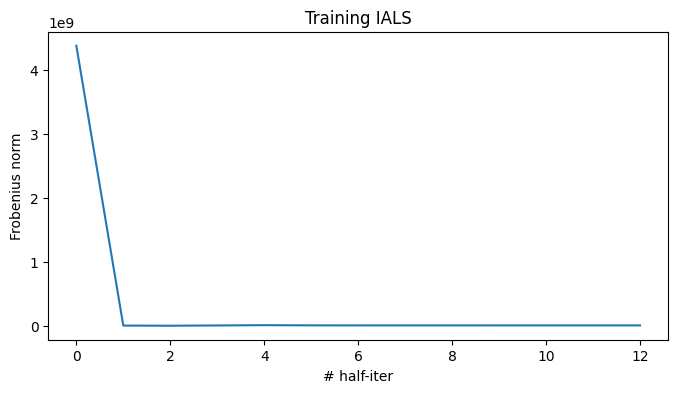

In [42]:
plt.figure(figsize=(8,4))
plt.plot(loss_history)
plt.title("Training IALS")
plt.xlabel("# half-iter")
plt.ylabel("Frobenius norm")
plt.show()

#### Посмотрим примеры рекомендаций для случайной пары юзеров

In [68]:
def show_IALS_comparison(dataset, ials_predicted, user_id):
    """Similar to ALS"""
    return show_ALS_comparison(dataset, ials_predicted, user_id)

In [69]:
show_IALS_comparison(dataset_train, ials_predicted, user_id=3)

,artist,track,id
0,Чиж & Co,О любви,17887582
1,Би-2,Лайки,37232249
2,Моральный кодекс,Первый снег,20713774
3,Константин Никольский,Мой друг художник и поэт,41551795
4,"Гарик Сукачёв, Неприкасаемые",Напои меня водой,20878423
5,Виктор,Звезда по имени Солнце,9550368


,artist,track,id
0,ДДТ,Это всё…,1695521
1,Танцы Минус,Половинка,27317897
2,Браво,Этот город,25861605
3,ДДТ,Просвистела,14662829
4,Алиса,Трасса Е-95,24112220
5,Агата Кристи,Как на войне,24442538
6,Nautilus Pompilius,"Крылья (Из к/ф ""Брат"")",33875380
7,Nautilus Pompilius,Прогулки по воде,6024175
8,Смысловые Галлюцинации,Вечно молодой,32476894
9,ДДТ,Осенняя,1695567


In [70]:
show_IALS_comparison(dataset_train, ials_predicted, user_id=8)

,artist,track,id
0,"Timmy Trumpet, Savage",Freaks,18385776
1,"Burak Yeter, Danelle Sandoval",Tuesday,29569939
2,Тима Белорусских,Незабудка,44184116
3,"Aaron Smith, Krono, Luvli",Dancin,21519270
4,RASA,Под фонарём,39917908
5,Robin Berrygold,Don't Think I Will Forgive You,21998692
6,Rompasso,Angetenar,41667460
7,Triplo Max,Shadow,44484514
8,"RaiM, Adil, Artur",Симпа,49252712
9,Rompasso,Ignis,41918198


,artist,track,id
0,Alan Walker,Fade,21259169
1,Myriam Fares,Ghmorni,19167393
2,Natalie Summer,In My Mind,42922448
3,Basshunter,Now You're Gone,2144135
4,"Dwin, ECHO",Sweet Dreams,39164351
5,INNA,Hot,606742
6,"Dynoro, Gigi D'Agostino",In My Mind,39257277
7,ANIVAR,Украду,46104677
8,HammAli & Navai,Пустите меня на танцпол,39307896
9,"Адлер Коцба, Timran",Запах моей женщины,40847731


__Вывод__

* IALS рекомендует тоже разумно, стиль рекомендованных треков похож на историю юзеров.

## 2. Метрика предсказаний MRR@100

In [71]:
def MRR100(test_items_ids, predicted_top100s):
    """
    Mean Reciprocal Rank at 100
    ----------------------------
    test_items_ids: массив (L,) из индексов удаленных айтемов для каждого из L тестовых юзеров
    predicted_top100s: массив (L,100) с топ 100 рекомендациями (айди треков) соответствующего юзера
    """
    # if number of predictions is cut for a faster test
    if len(predicted_top100s) < len(test_items_ids):
        test_items_ids = test_items_ids[:len(predicted_top100s)]

    n_queries = len(test_items_ids)
    ranks = []

    for test_item, top100 in tqdm(zip(test_items_ids, predicted_top100s), total=n_queries):
        test_track_id = item_ids[test_item]

        if test_track_id in top100:
            p = list(top100).index(test_track_id)
            ranks += [1 / (p + 1)]
        else:
            ranks += [0]

    MRR100 = np.mean(ranks)
    return MRR100

#### Посчитаем метрику MRR@100 для Item2Item

* Так как кол-во айтемов-соседей и кандидатов ограничено гиперпараметрами, для некоторых юзеров может не набраться полный топ 100 рекомендаций $⇒$ будет расчитывать метрику по такому неполному набору.

In [72]:
def i2i_test_predict(dataset, test_users_ids, similarities, neighbors, test_size=None, k=20):
    n_users = len(test_users_ids)
    if test_size:
        size = min(test_size, n_users)
    else:
        size = n_users
    print(f'Testing Item2Item for {size} test users out of {n_users}')

    predicted_top100s = np.zeros(shape=(size, 100), dtype=int)
    sample = test_users_ids[:size]

    for i, test_user in tqdm(enumerate(sample), total=size):
        recs = top_N_recommendation(dataset, test_user, similarities, neighbors, k)
        top100 = np.array([rec[0] for rec in recs]).astype(int)

        if len(top100) < 100:
            print(f'Warning: for user {test_user} only {len(top100)} items recommended, padded with zeroes')
            top100 = np.pad(top100, (0, 100-len(top100)), mode='constant', constant_values=0)

        predicted_top100s[i] = top100

    return predicted_top100s

In [73]:
predicted_top100s_i2i = i2i_test_predict(dataset_train, test_users_ids, similarities, neighbors, 1000)

Testing Item2Item for 1000 test users out of 2746


  0%|          | 0/1000 [00:00<?, ?it/s]

In [74]:
mrr_i2i = MRR100(test_items_ids, predicted_top100s_i2i)

print(f'MRR@100 (Item2Item): {mrr_i2i:.3f} (sample size = {len(predicted_top100s_i2i)})')

  0%|          | 0/1000 [00:00<?, ?it/s]

MRR@100 (Item2Item): 0.062 (sample size = 1000)


#### Посчитаем метрику MRR@100 для ALS

In [75]:
def als_test_predict(dataset, test_users_ids, als_predicted, test_size=None):
    n_users = len(test_users_ids)
    if test_size:
        size = min(test_size, n_users)
    else:
        size = n_users
    print(f'Testing ALS for {size} test users out of {n_users}')

    predicted_top100s = np.zeros(shape=(size, 100), dtype=int)
    sample = test_users_ids[:size]

    for i, test_user in tqdm(enumerate(sample), total=size):
        top100 = top_N_recs_ALS(dataset, als_predicted, test_user, N=100).astype(int)

        if len(top100) < 100:
            print(f'Warning: for user {test_user} only {len(top100)} items recommended, padded with zeroes')
            top100 = np.pad(top100, (0, 100-len(top100)), mode='constant', constant_values=0)

        predicted_top100s[i] = top100

    return predicted_top100s

In [76]:
predicted_top100s_als = als_test_predict(dataset_train, test_users_ids, als_predicted)

Testing ALS for 2746 test users out of 2746


  0%|          | 0/2746 [00:00<?, ?it/s]

In [77]:
mrr_als = MRR100(test_items_ids, predicted_top100s_als)

print(f'MRR@100 (ALS): {mrr_als:.3f} (sample size = {len(predicted_top100s_als)})')

  0%|          | 0/2746 [00:00<?, ?it/s]

MRR@100 (ALS): 0.032 (sample size = 2746)


#### Померим метрику MRR@100 на тестовых юзерах для IALS

In [78]:
def ials_test_predict(dataset, test_users_ids, ials_predicted, test_size=None):
    """Similar to ALS"""
    print('(Implicit)')
    return als_test_predict(dataset, test_users_ids, ials_predicted, test_size)

In [79]:
predicted_top100s_ials = ials_test_predict(dataset_train, test_users_ids, ials_predicted)

(Implicit)
Testing ALS for 2746 test users out of 2746


  0%|          | 0/2746 [00:00<?, ?it/s]

In [80]:
mrr_ials = MRR100(test_items_ids, predicted_top100s_ials)

print(f'MRR@100 (IALS): {mrr_ials:.3f} (sample size = {len(predicted_top100s_ials)})')

  0%|          | 0/2746 [00:00<?, ?it/s]

MRR@100 (IALS): 0.050 (sample size = 2746)


__Результат (с дефолтными параметрами)__

* MRR@100 Item2Item: **0.062**
* MRR@100 ALS: **0.032**
* MRR@100 IALS: **0.050**

## 3. Подбор параметров для максимизации MRR@100

Переберем для каждого из алгоритмов значения гиперпараметров.

1. Item2Item
  - k_neighbors (default=30) - кол-во соседей, учитываемых в матрице попарных дистанций items-items 
  - k_candidates (default=20) - кол-во кандидатов для каждого айтема из истории юзера

Для ускорения возьмем сэмпл юзеров размера 100 (в расчете выше брали 1000). Посчитаем еще раз метрику при default параметрах для сравнимости.

In [82]:
print('Default parameters -> baseline for this users sample')
sims_matrix = jaccard_pairwise_similarity(dataset_train, verbose=False)
sims, neighs = top_k_neighbors(similarity_matrix, k=30, verbose=False)
preds = i2i_test_predict(dataset_train, test_users_ids, sims, neighs, test_size=100, k=20)
mrr = MRR100(test_items_ids, preds)
print(f'k_neighbors = 30, k_candidates = 20: MRR@100 = {mrr:.3f}')

k_neighbors = [50, 200]
k_candidates = [50, 100]

for k_neigh in tqdm(k_neighbors, total=len(k_neighbors)):
    for k_cand in k_candidates:
        sims_matrix = jaccard_pairwise_similarity(dataset_train, verbose=False)
        sims, neighs = top_k_neighbors(similarity_matrix, k=k_neigh, verbose=False)
        preds = i2i_test_predict(dataset_train, test_users_ids, sims, neighs, 100, k_cand)
        mrr = MRR100(test_items_ids, preds)
        print(f'k_neighbors = {k_neigh}, k_candidates = {k_cand}: MRR@100 = {mrr:.3f}')

Default parameters -> baseline for this users sample


  0%|          | 0/10000 [00:00<?, ?it/s]

Testing Item2Item for 100 test users out of 2746


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

k_neighbors = 30, k_candidates = 20: MRR@100 = 0.038


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Testing Item2Item for 100 test users out of 2746


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

k_neighbors = 50, k_candidates = 50: MRR@100 = 0.039


  0%|          | 0/10000 [00:00<?, ?it/s]

Testing Item2Item for 100 test users out of 2746


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

k_neighbors = 50, k_candidates = 100: MRR@100 = 0.039


  0%|          | 0/10000 [00:00<?, ?it/s]

Testing Item2Item for 100 test users out of 2746


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

k_neighbors = 200, k_candidates = 50: MRR@100 = 0.030


  0%|          | 0/10000 [00:00<?, ?it/s]

Testing Item2Item for 100 test users out of 2746


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

k_neighbors = 200, k_candidates = 100: MRR@100 = 0.032


Посчитаем метрику для лучшей комбинации параметров на сэмпле размера 1000:

In [83]:
sims_matrix = jaccard_pairwise_similarity(dataset_train, verbose=False)
sims, neighs = top_k_neighbors(similarity_matrix, k=50, verbose=False)
preds = i2i_test_predict(dataset_train, test_users_ids, sims, neighs, test_size=1000, k=50)
mrr = MRR100(test_items_ids, preds)
print(f'k_neighbors = 50, k_candidates = 50: MRR@100 = {mrr:.3f}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Testing Item2Item for 1000 test users out of 2746


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

k_neighbors = 50, k_candidates = 50: MRR@100 = 0.064


__Вывод:__ MRR улучшился до 0.064; небольшое увеличение "круга поиска" улучшает метрику, но дальнейшее увеличение не помогает - все ±релеватные айтемы уже найдены и в топ выбиваются менее релевантные.

2. ALS
  - k_features (default=32) - размер латентного пространства для эмбеддингов юзеров/айтемов
  - lambda (default=1e-4) - регуляризация

In [107]:
k_features = [64, 128]
lambdas = [1e-2, 1e-6]

for k_feat in tqdm(k_features, total=len(k_features)):
    for lambda_ in lambdas:
        X, Y, loss_history = ALS(dataset_als, n_steps=10, k=k_feat, lam=lambda_)
        als_pred = X.dot(Y.T)
        preds = als_test_predict(dataset_train, test_users_ids, als_pred)
        mrr = MRR100(test_items_ids, preds)
        print(f'k_features = {k_feat}, lambda = {lambda_}: MRR@100 = {mrr:.3f}')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing ALS for 2746 test users out of 2746


  0%|          | 0/2746 [00:00<?, ?it/s]

  0%|          | 0/2746 [00:00<?, ?it/s]

k_features = 64, lambda = 0.01: MRR@100 = 0.036


  0%|          | 0/10 [00:00<?, ?it/s]

Testing ALS for 2746 test users out of 2746


  0%|          | 0/2746 [00:00<?, ?it/s]

  0%|          | 0/2746 [00:00<?, ?it/s]

k_features = 64, lambda = 1e-06: MRR@100 = 0.036


  0%|          | 0/10 [00:00<?, ?it/s]

Testing ALS for 2746 test users out of 2746


  0%|          | 0/2746 [00:00<?, ?it/s]

  0%|          | 0/2746 [00:00<?, ?it/s]

k_features = 128, lambda = 0.01: MRR@100 = 0.039


  0%|          | 0/10 [00:00<?, ?it/s]

Testing ALS for 2746 test users out of 2746


  0%|          | 0/2746 [00:00<?, ?it/s]

  0%|          | 0/2746 [00:00<?, ?it/s]

k_features = 128, lambda = 1e-06: MRR@100 = 0.040


__Вывод:__ MRR улучшился до 0.040; увеличение кол-ва фичей заметно улучшает метрику, а регуляризация влияет не сильно, но небольшие значения работают чуть лучше (1e-4..1e-6).

3. IALS
  - k_features (default=32) - размер латентного пространства для эмбеддингов юзеров/айтемов
  - lambda (default=1e-4) - регуляризация
  - alpha (default=1e2) - вес позитивного отклика

In [ ]:
# k_features = [64, 128]
# lambdas = [1e-2, 1e-6]
# alphas = [40, 70]

С дефолтными параметрами обучение 6 итераций IALS занимает __~2ч__, поэтому прогнать сетку значений для всех 3 параметров займет много времени, однако:

- первые несколько обучений были сделаны с __alpha = 1e5__ и __1e3__, и это дало сильно ниже качество: __MRR = 0.006__ и __0.030__ соответственно, то есть для данного сэмпла данных нужна не очень большая alpha, не нужно так сильно компенсировать нехватку явного фидбека.

Также исходя из перебора значений параметров для ALS можно сделать несколько выводов и для IALS:
* увеличение кол-ва фичей положительно сказывается на качестве, то есть у IALS точно есть запас улучшения метрики
* регуляризация влияет на данном датасете несильно, но чуть лучше с небольшими значениями (1e-4..1e-6)

__Вывод:__ с учетом подбора гиперпараметров достигнута метрика на моделях
* MRR@100 Item2Item: **0.064**  
* MRR@100 ALS: **0.040**
* MRR@100 IALS: **0.050**

## 4. Сравнение похожести айтемов для item2item, ALS, IALS


Замерим насколько получаются похожими топы рекомендаций разных алгоритмов. В качестве меры схожести возьмем пересечение рекомендаций и IoU.

In [84]:
def compare_two_recs(preds_1, preds_2):
    intersection = np.mean([len(set(a).intersection(set(b))) for a, b in zip(preds_1, preds_2)])
    IoU = np.mean([len(set(a).intersection(b)) / len(set(a).union(set(b))) 
                  for a, b in zip(preds_1, preds_2)])
    return intersection, IoU

In [85]:
L = min(predicted_top100s_i2i.shape[0], 
        predicted_top100s_als.shape[0], 
        predicted_top100s_ials.shape[0])

In [86]:
intersection, IoU = compare_two_recs(predicted_top100s_i2i[:L], predicted_top100s_als[:L])
print(f'Item2Item vs. ALS: intersection = {intersection:.0f}, IoU = {IoU:.3f}')

intersection, IoU = compare_two_recs(predicted_top100s_i2i[:L], predicted_top100s_ials[:L])
print(f'Item2Item vs. IALS: intersection = {intersection:.0f}, IoU = {IoU:.3f}')

intersection, IoU = compare_two_recs(predicted_top100s_als[:L], predicted_top100s_ials[:L])
print(f'ALS vs. IALS: intersection = {intersection:.0f}, IoU = {IoU:.3f}')

Item2Item vs. ALS: intersection = 38, IoU = 0.244
Item2Item vs. IALS: intersection = 37, IoU = 0.231
ALS vs. IALS: intersection = 42, IoU = 0.273


__Вывод__

* Все 3 алгоритма довольно похожи в рекомендациях, в среднем на юзера ~40 общих айтемов в топ-100 каждого алгоритма
* Это означает, что все алгоритмы обучились корректно, результаты согласуются
* Больше всего схожи ALS и IALS, у них в среднем 42 айтема из 100 повторяются